In [ ]:
from os import path, listdir
from PIL import Image
import numpy as np

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
def get_data(directory: str) -> "tuple[np.ndarray, np.ndarray]":
    ima = listdir(path.join(directory, "PNEUMONIA"))
    nema = listdir(path.join(directory, "NORMAL"))
    size = len(ima) + len(nema)
    X = np.empty((size, 250, 350), dtype=np.uint8)
    y = np.empty((size), dtype=np.uint8)
    for i, file in enumerate(ima):
        X[i] = np.asarray(Image.open(path.join(directory, "PNEUMONIA", file)))
        y[i] = 1
    for i, file in enumerate(nema):
        X[len(ima) + i] = np.asarray(Image.open(path.join(directory, "NORMAL", file)))
        y[len(ima) + i] = 0
    return X , y

In [8]:
from modeli_stefan import make_model_1

In [10]:
directory_train = "../chest_xray_norm/train"
x_train, y_train = get_data(directory_train)

directory_val = "../chest_xray_norm/val"
x_val, y_val = get_data(directory_val)

model = make_model_1(x_train[0].shape)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 250, 350)]        0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 250, 350)          0         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 250, 350)          0         
_________________________________________________________________
tf.clip_by_value_2 (TFOpLamb (None, 250, 350)          0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 250, 350, 1)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 248, 348, 16)      160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 82, 116, 16)       0   

In [11]:
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint

In [12]:
class MyModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch,logs)\

        # Also save the optimizer state
        filepath = self._get_file_path(epoch=epoch, 
            logs=logs)
        filepath = filepath.rsplit( ".", 1 )[ 0 ] 
        filepath += ".pkl"

        with open(filepath, 'wb') as fp:
              pickle.dump(
                {
                  'opt': model.optimizer.get_config(),
                  'epoch': epoch+1
                 # Add additional keys if you need to store more values
                }, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print('\nEpoch %05d: saving optimizaer to %s' % (epoch + 1, filepath))

In [13]:
save_dir = "./checkpoints/stefan/model_1_checkpoints"

In [14]:
checkpoint_cb = MyModelCheckpoint(
path.join(save_dir, 'model-{epoch:03d}-{val_loss:.5f}.hdf5'),
monitor='val_loss',verbose=1)

In [15]:
history = model.fit(x_train, y_train, epochs=50, batch_size=0, verbose=1,
                    shuffle=True, validation_data=(x_val,y_val),callbacks=[checkpoint_cb])

2022-05-26 17:42:33.675094: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-26 17:42:33.700373: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


Epoch 1/50


2022-05-26 17:42:34.311026: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-26 17:42:34.731889: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-05-26 17:42:35.773333: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-05-26 17:42:35.800259: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


163/163 [==============================] - 19s 89ms/step - loss: 0.4480 - accuracy: 0.8012 - precision_2: 0.8118 - recall_2: 0.9630 - val_loss: 1.5300 - val_accuracy: 0.5625 - val_precision_2: 0.5333 - val_recall_2: 1.0000

Epoch 00001: saving model to ./checkpoints/stefan/model_1_checkpoints/model-001-1.52997.hdf5

Epoch 00001: saving optimizaer to ./checkpoints/stefan/model_1_checkpoints/model-001-1.52997.pkl
Epoch 2/50
163/163 [==============================] - 13s 79ms/step - loss: 0.1664 - accuracy: 0.9378 - precision_2: 0.9601 - recall_2: 0.9548 - val_loss: 0.7136 - val_accuracy: 0.5625 - val_precision_2: 0.5333 - val_recall_2: 1.0000

Epoch 00002: saving model to ./checkpoints/stefan/model_1_checkpoints/model-002-0.71363.hdf5

Epoch 00002: saving optimizaer to ./checkpoints/stefan/model_1_checkpoints/model-002-0.71363.pkl
Epoch 3/50
163/163 [==============================] - 13s 79ms/step - loss: 0.1285 - accuracy: 0.9546 - precision_2: 0.9725 - recall_2: 0.9664 - val_loss: 0.23

163/163 [==============================] - 16s 99ms/step - loss: 0.0267 - accuracy: 0.9908 - precision_2: 0.9926 - recall_2: 0.9952 - val_loss: 0.1188 - val_accuracy: 0.9375 - val_precision_2: 0.8889 - val_recall_2: 1.0000

Epoch 00020: saving model to ./checkpoints/stefan/model_1_checkpoints/model-020-0.11879.hdf5

Epoch 00020: saving optimizaer to ./checkpoints/stefan/model_1_checkpoints/model-020-0.11879.pkl
Epoch 21/50
163/163 [==============================] - 14s 86ms/step - loss: 0.0294 - accuracy: 0.9894 - precision_2: 0.9943 - recall_2: 0.9914 - val_loss: 0.3438 - val_accuracy: 0.7500 - val_precision_2: 0.6667 - val_recall_2: 1.0000

Epoch 00021: saving model to ./checkpoints/stefan/model_1_checkpoints/model-021-0.34383.hdf5

Epoch 00021: saving optimizaer to ./checkpoints/stefan/model_1_checkpoints/model-021-0.34383.pkl
Epoch 22/50
163/163 [==============================] - 14s 88ms/step - loss: 0.0261 - accuracy: 0.9906 - precision_2: 0.9937 - recall_2: 0.9936 - val_loss: 1.

163/163 [==============================] - 14s 85ms/step - loss: 0.0192 - accuracy: 0.9933 - precision_2: 0.9952 - recall_2: 0.9957 - val_loss: 0.4930 - val_accuracy: 0.8125 - val_precision_2: 0.7273 - val_recall_2: 1.0000

Epoch 00039: saving model to ./checkpoints/stefan/model_1_checkpoints/model-039-0.49299.hdf5

Epoch 00039: saving optimizaer to ./checkpoints/stefan/model_1_checkpoints/model-039-0.49299.pkl
Epoch 40/50
163/163 [==============================] - 14s 83ms/step - loss: 0.0092 - accuracy: 0.9959 - precision_2: 0.9971 - recall_2: 0.9974 - val_loss: 0.4582 - val_accuracy: 0.8750 - val_precision_2: 0.8000 - val_recall_2: 1.0000

Epoch 00040: saving model to ./checkpoints/stefan/model_1_checkpoints/model-040-0.45821.hdf5

Epoch 00040: saving optimizaer to ./checkpoints/stefan/model_1_checkpoints/model-040-0.45821.pkl
Epoch 41/50
163/163 [==============================] - 14s 84ms/step - loss: 0.0157 - accuracy: 0.9955 - precision_2: 0.9971 - recall_2: 0.9968 - val_loss: 0.

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_2', 'recall_2', 'val_loss', 'val_accuracy', 'val_precision_2', 'val_recall_2'])

In [17]:
import matplotlib.pyplot as plt

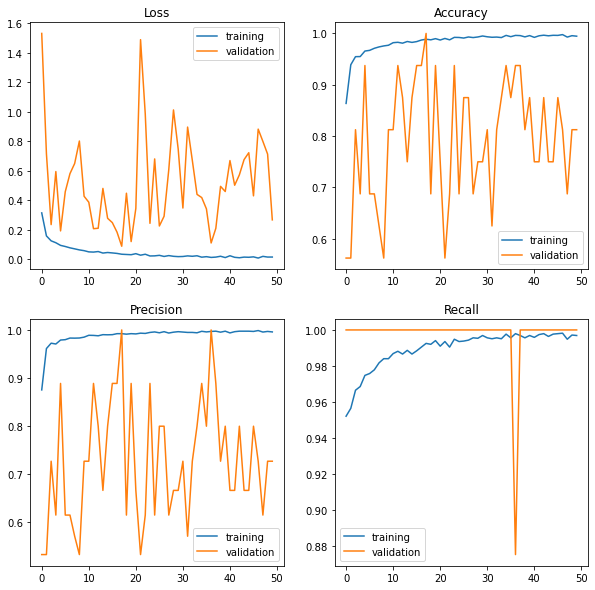

In [18]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.title('Loss')
plt.plot(history.epoch, history.history['loss'], label='training')
plt.plot(history.epoch, history.history['val_loss'], label='validation')
plt.legend(loc='best')

plt.subplot(2, 2, 2)
plt.title('Accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='training')
plt.plot(history.epoch, history.history['val_accuracy'], label='validation')
plt.legend(loc='best')

plt.subplot(2, 2, 3)
plt.title('Precision')
plt.plot(history.epoch, history.history['precision_2'], label='training')
plt.plot(history.epoch, history.history['val_precision_2'], label='validation')
plt.legend(loc='best')

plt.subplot(2, 2, 4)
plt.title('Recall')
plt.plot(history.epoch, history.history['recall_2'], label='training')
plt.plot(history.epoch, history.history['val_recall_2'], label='validation')
plt.legend(loc='best')

plt.show()

In [ ]:
model.save("./modeli/stefan/model_5_epoha_70.h5")

In [ ]:
import json
  
# Serializing json 
json_history = json.dumps(history.history, indent = 4)
  
# Writing json
with open("./modeli/stefan/model_5_epoha_70.json", "w") as outfile:
    outfile.write(json_history)

In [ ]:
# loadovanje modela
from tensorflow.keras.models import load_model

model2 = load_model('./modeli/stefan/model_5_epoha_70.h5')

In [ ]:
#loadovanje istorije

with open('./modeli/stefan/model_5_epoha_70.json', 'r') as openfile:
    # Reading from json file
    history2 = json.load(openfile)


In [ ]:
len(history2['loss'])

In [ ]:
#history.history.keys()

In [ ]:
#len(history.history['loss'])

In [26]:
directory_test = "../chest_xray_norm/test"
x_test, y_test = get_data(directory_test)

In [43]:
y_pred = model.predict(x_test)

In [ ]:
#y_pred_round = np.round(y_pred)

In [44]:
y_pred = y_pred>0.5

In [45]:
y_pred = y_pred.astype(int)

In [ ]:
#y_test

In [ ]:
#y_pred

In [46]:
y_pred = np.ravel(y_pred)

In [47]:
tacnost = [y_pred==y_test]

In [48]:
#tacnost

In [49]:
tacnost = np.average(tacnost)

In [50]:
tacnost

0.7419871794871795

In [34]:
best_model_checkpoint_path = "./checkpoints/stefan/model_1_checkpoints/model-037-0.10930.hdf5"

In [35]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle

def load_model_data(model_path):
    model = load_model(model_path)
    
    return model

In [36]:
model_best = load_model_data(best_model_checkpoint_path)

In [37]:
y_pred_best = model_best.predict(x_test)

In [38]:
y_pred_best = np.ravel(y_pred_best)
y_pred_best = y_pred_best>0.5

In [39]:
y_pred_best = y_pred_best.astype(int)

In [40]:
tacnost = [y_pred_best==y_test]

In [41]:
tacnost = np.average(tacnost)

In [42]:
tacnost

0.7644230769230769